# Estimación del precio de una vivienda 
### Diego Escanciano Igualador

En este trabajo de aprendizaje supervisado emplearemos la base de datos de viviendas [House Sales in King COunty, USA](https://www.kaggle.com/harlfoxem/housesalesprediction). En primer lugar, para familiarizarnos con los datos, haremos un análisis exploratorio, posteriormente haremos un preprocesado de los datos para poder aplicar algoritmos de Machine Learning en las mejores condiciones y por útlimo aplicaremos dichas técnicas de machine learning sobre los datos preprocesados.

Para cada vivienda, se tienen los siguientes atributos, características o features (o descriptores, o dimensiones...):

| Atributo | descripción |
| :- |:- |
|*id*| identificador de la vivienda|
| *date*| fecha
| *price*| precio
| *bedrooms*| número de habitaciones
| *bathrooms*| número de baños/aseos
| *sqtf_living*| superficie habitable (en pies al cuadrado)
| *sqft_lot*| superficie de la parcela (en pies al cuadrado)
| *floors*| número de plantas
| *waterfront*| indica si la vivienda tiene acceso a un lago
| *view*| tipo de vista (variable numérica)
| *condition*| condición de la vivienda (variable númerica)
| *grade*| medida de la calidad de la construcción (variable numérica)
| *sqft_above*| superficie por encima del suelo (en pies al cuadrado)
| *sqft_basement*| superficie del sótano (en pies al cuadrado)
| *yr_built*| año de construcción de la vivienda
| *yr_renovated*| año de renovación de la vivienda
| *lat*| latitud de la parcela
| *long*| longitud de la parcela
| *sqft_living15*| superficie habitable promedio de los 15 vecinos más cercanos 				
| *sqft_lot15*| superficie de la parcela promedio de los 15 vecinos más cercanos

Vamos a utilizar **DataFrames** de [Pandas](http://pandas.pydata.org/) y posteriormente diferentes modulos de [Sklearn](https://scikit-learn.org/stable/).

In [1]:
# Cargamos librerías imprescindibles
import numpy  as np  
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import metrics
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt # para dibujar
%matplotlib inline


In [2]:
house_data = pd.read_csv("https://raw.githubusercontent.com/DiegoEscanciano/UCM_MACH/main/Data/kc_house_data.csv") # cargamos fichero
house_data.head()                                  # visualizamos 5 primeras filas

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Funciones útiles:

Emplearemos una serie de funciones que nos ayudarán a llevar a cabo nuestro análisis:

In [3]:
# Función que nos devuelve los valores que esten muy correlacionados

def remove_collinear_features(x, threshold):
    
    # Create correlation matrix:
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    
    # Work through the iterations setup:
    for i in iters:
        for j in range(i+1):
            items = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = items.columns
            row = items.index
            val = abs(items.values)
            
            # Compare against threshold:
            if val >= threshold:
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])
                
    cols_to_drop = set(drop_cols)
    x = x.drop(columns = cols_to_drop, axis=1)
    
    return x

# Función que resume los atributos clave del dataframe

def df_characteristics(df):
    
    print('El tamaño del dataframe es: {}.'.format(df.shape), '\n')
    
    df_num = df.select_dtypes(include=[np.number])
    print('Este dataframe tiene {} valores numéricos.'.format(df_num.shape[1]), '\n')
    print(df_num.columns, '\n')
    
    df_cat = df.select_dtypes(exclude=[np.number])
    print('Este dataframe tiene {} valores categóricos.'.format(df_cat.shape[1]), '\n')
    print(df_cat.columns)

# Función que devuelve los valores nulos del dataframe

def check_null_values(df):
    
    nanframe = pd.DataFrame((df.isnull().sum() / len(df)) * 100)
    nanframe.columns = ['NaN(%)']
    nanframe['Blank_Record_Counts'] = pd.DataFrame(df.isnull().sum())
    nanframe = nanframe[nanframe['Blank_Record_Counts'] != 0]
    return nanframe.sort_values(by='NaN(%)', ascending=False).reset_index()

def algoritmo_regresion(y_test, model_y_pred):
  rmse = np.sqrt(mean_squared_error(y_test, model_y_pred))
  rsq = r2_score(y_test, model_y_pred)
  mae = mean_absolute_error(y_test, model_y_pred)

  return rmse, rsq, mae

## Tratamiento de la base de datos inicial

En primer lugar observamos la base de datos:

In [4]:
house_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [5]:
df_characteristics(house_data)

El tamaño del dataframe es: (21613, 21). 

Este dataframe tiene 20 valores numéricos. 

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object') 

Este dataframe tiene 1 valores categóricos. 

Index(['date'], dtype='object')


Podemos observar que todas las variables son de tipo numérico, a extepción de la variable date, así que no tenemos que codificar ninguna de ellas porque eliminaremos los atributos 'id' y 'date' que no nos aportan información al ser variables identificativas.

In [6]:
# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

Además transforemos las variables de superficie para expresarlas en $m^2$ y posteriormente renombraremos las columnas.

In [7]:
# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

También puede resultar interesante añadir nuevas variables como la de años de la vivienda, definida como el año actual (2023) menos el año de construcción.

In [8]:
# añadimos las nuevas variables
house_data['years']            = 2023 - house_data['yr_built']
house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
house_data['log_sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
house_data['lat_plus_long']    = house_data['lat']*house_data['long']

# visualizamos
house_data.head()

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,zip_code,lat,long,sqm_living15,sqm_lot15,years,bedrooms_squared,bed_bath_rooms,log_sqm_living,lat_plus_long
0,221900.0,3,1.00,109.625587,524.902176,1.0,0,0,3,7,...,98178,47.5112,-122.257,124.490074,524.902176,68,9,3.00,4.697071,-5808.576778
1,538000.0,3,2.25,238.760813,672.803816,2.0,0,0,3,7,...,98125,47.7210,-122.319,157.006138,709.686323,72,9,6.75,5.475462,-5837.184999
2,180000.0,2,1.00,71.535341,929.030400,1.0,0,0,3,6,...,98028,47.7379,-122.233,252.696269,748.984308,90,4,2.00,4.270192,-5835.146731
3,604000.0,4,3.00,182.089958,464.515200,1.0,0,0,5,7,...,98136,47.5208,-122.393,126.348134,464.515200,58,16,12.00,5.204501,-5816.213274
4,510000.0,3,2.00,156.077107,750.656563,1.0,0,0,3,8,...,98074,47.6168,-122.045,167.225472,697.051509,36,9,6.00,5.050350,-5811.392356


### Valores duplicados

Interesa eliminar los valores duplicados para evitar la redundancia en nuestros análisis. Para ello:

In [9]:
house_data[house_data.duplicated()==True] # Valores duplicados

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,zip_code,lat,long,sqm_living15,sqm_lot15,years,bedrooms_squared,bed_bath_rooms,log_sqm_living,lat_plus_long
3951,550000.0,4,1.75,223.896326,784.751979,2.0,0,3,4,8,...,98074,47.6499,-122.088,234.115661,1373.943059,87,16,7.00,5.411183,-5817.480991
4352,259950.0,2,2.00,99.406253,60.294073,2.0,0,0,3,9,...,98106,47.5213,-122.357,99.406253,86.214021,15,4,4.00,4.599215,-5814.563704
14983,585000.0,3,2.50,212.747962,472.783571,2.0,0,0,3,9,...,98006,47.5443,-122.172,212.747962,741.737871,22,9,7.50,5.360108,-5808.582220
20054,555000.0,3,2.50,180.231898,298.311661,2.0,0,0,3,8,...,98027,47.5644,-122.093,174.657715,285.955557,14,9,7.50,5.194244,-5807.280289
20524,529500.0,3,2.25,130.993286,84.077251,3.0,0,0,3,9,...,98116,47.5818,-122.402,140.283590,125.604910,9,9,6.75,4.875146,-5824.107484


Tenemos 5 valores duplicados en nuestro dataframe. El método a seguir en este caso es eliminarlos.

In [10]:
house_data=house_data.drop_duplicates()
house_data # Ahora tenemos 21608 registros en lugar de 21613

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,zip_code,lat,long,sqm_living15,sqm_lot15,years,bedrooms_squared,bed_bath_rooms,log_sqm_living,lat_plus_long
0,221900.0,3,1.00,109.625587,524.902176,1.0,0,0,3,7,...,98178,47.5112,-122.257,124.490074,524.902176,68,9,3.00,4.697071,-5808.576778
1,538000.0,3,2.25,238.760813,672.803816,2.0,0,0,3,7,...,98125,47.7210,-122.319,157.006138,709.686323,72,9,6.75,5.475462,-5837.184999
2,180000.0,2,1.00,71.535341,929.030400,1.0,0,0,3,6,...,98028,47.7379,-122.233,252.696269,748.984308,90,4,2.00,4.270192,-5835.146731
3,604000.0,4,3.00,182.089958,464.515200,1.0,0,0,5,7,...,98136,47.5208,-122.393,126.348134,464.515200,58,16,12.00,5.204501,-5816.213274
4,510000.0,3,2.00,156.077107,750.656563,1.0,0,0,3,8,...,98074,47.6168,-122.045,167.225472,697.051509,36,9,6.00,5.050350,-5811.392356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,142.141651,105.073338,3.0,0,0,3,8,...,98103,47.6993,-122.346,142.141651,140.190687,14,9,7.50,4.956824,-5835.818558
21609,400000.0,4,2.50,214.606022,540.045372,2.0,0,0,3,8,...,98146,47.5107,-122.362,170.012563,668.901888,9,16,10.00,5.368804,-5813.504273
21610,402101.0,2,0.75,94.761101,125.419104,2.0,0,0,3,7,...,98144,47.5944,-122.299,94.761101,186.456401,14,4,1.50,4.551359,-5820.747526
21611,400000.0,3,2.50,148.644864,221.852460,2.0,0,0,3,8,...,98027,47.5345,-122.069,130.993286,119.566212,19,9,7.50,5.001560,-5802.488881


### Análisis de datos missing

Vamos a llevar a cabo el análisis de datos missing.

In [11]:
check_null_values(house_data)

,index,NaN(%),Blank_Record_Counts


Por tanto no tenemos valores nulos. Si hubieramos tenido alguno podríamos haberlos sustituido por la media (en caso de variables continuas) o la moda (en caso de variables discretas) entre otras posibilidades.

### Normalización de la variable 'price'.

Vemos que la variable objetivo 'price' no se encuentra normalizada.

<AxesSubplot:xlabel='price', ylabel='Count'>

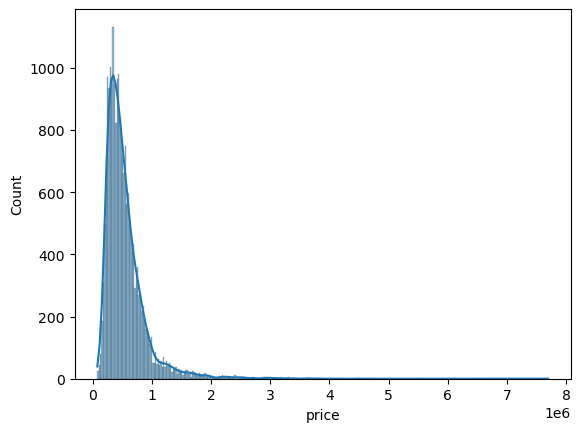

In [12]:
sns.histplot(data=house_data, x="price", kde=True) # Histograma

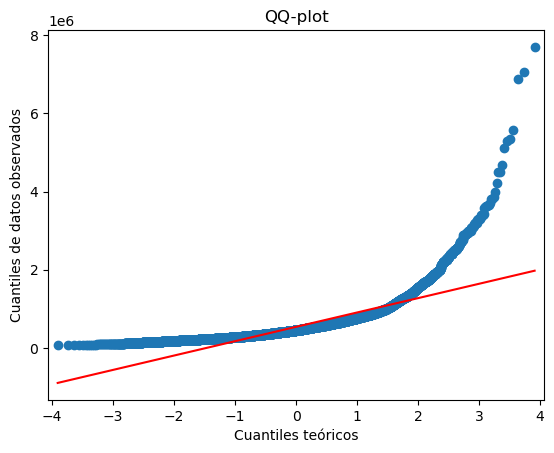

In [13]:
sm.qqplot(house_data['price'], line='s') # QQ-plot
plt.title("QQ-plot")
plt.xlabel("Cuantiles teóricos")
plt.ylabel("Cuantiles de datos observados")
plt.show() # Los datos no estan normalizados

Emplearemos una función logaritmica para normalizar los datos.

In [14]:
house_data_log = house_data.copy()
#house_data_log['price'] = np.log(house_data_log['price'])

In [15]:
house_data_log['price'] = np.log(house_data_log['price'])

Efectivamente vemos que los datos han sido normalizados:

<AxesSubplot:xlabel='price', ylabel='Count'>

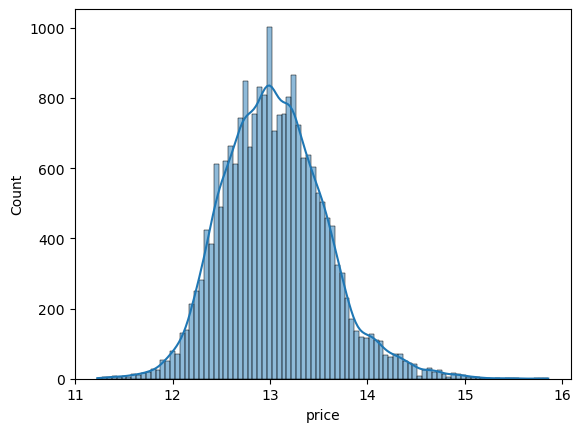

In [16]:
sns.histplot(data=house_data_log, x="price", kde=True) # Histograma

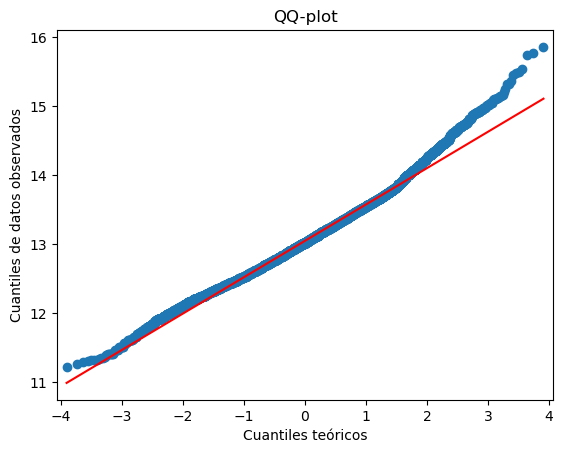

In [17]:
sm.qqplot(house_data_log['price'], line='s') # QQ-plot
plt.title("QQ-plot")
plt.xlabel("Cuantiles teóricos")
plt.ylabel("Cuantiles de datos observados")
plt.show()

## Análisis Exploratorio

Representamos los histogramas de algunos atributos:

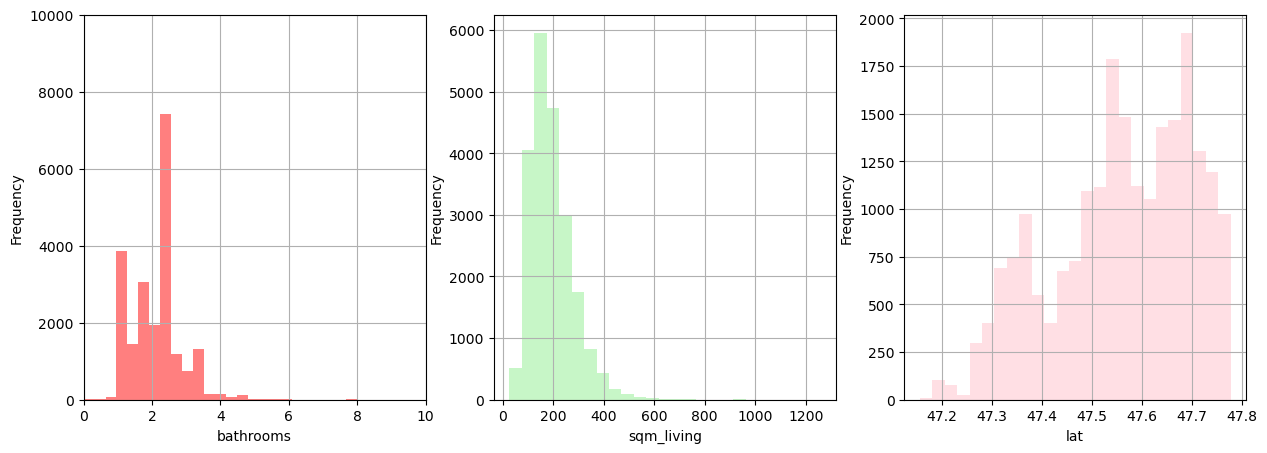

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
house_data['bathrooms'].plot.hist(alpha=0.5, bins=25, grid = True, color='red')
plt.axis([0, 10, 0, 10000])
plt.xlabel('bathrooms')

plt.subplot(1,3,2)
house_data['sqm_living'].plot.hist(alpha=0.5, bins=25, grid = True, color='lightgreen')
plt.xlabel('sqm_living')

plt.subplot(1,3,3)
house_data['lat'].plot.hist(alpha=0.5, bins=25, grid = True, color = 'pink')
plt.xlabel('lat')

plt.show()

Ya que hemos analizado las variables por separado, el siguiente paso en un análisis exploratorio es entender las relaciones entre cada una de las variables/atributos ($\mathbf{X}$) y la variable objetivo ($y$). 

Para ello vamos a utilizar un *Scatter Plot* con la variable objetivo definida $y$ como variable dependiente, y alguna una de las variables explicativas como variables independientes. En el caso de la variable *waterfront*, dado que ésta es binaria, vamos a utilizar un boxplot.

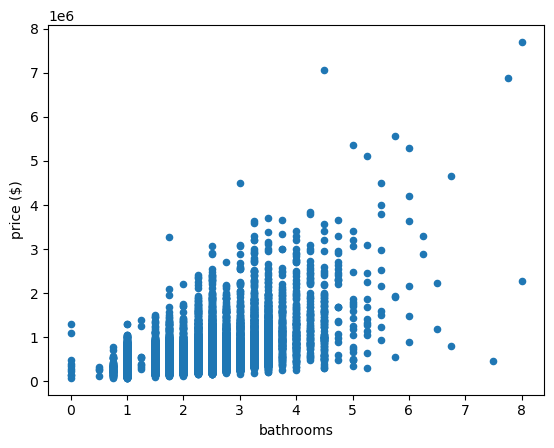

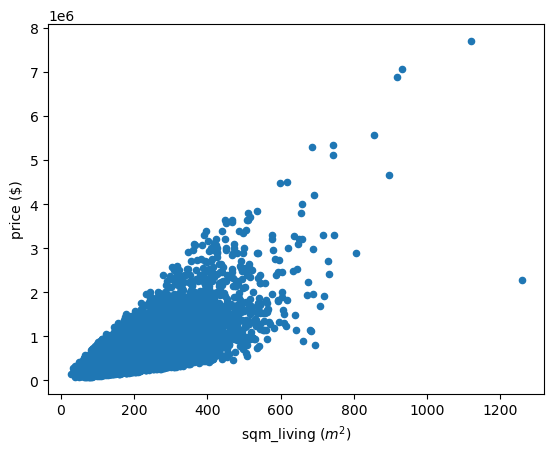

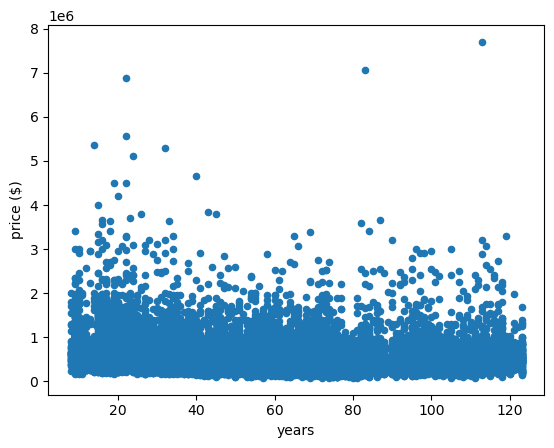

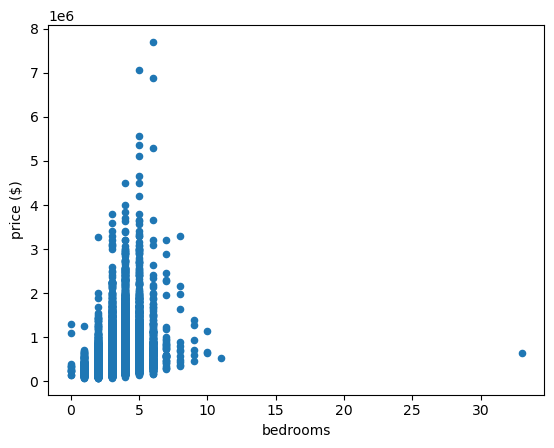

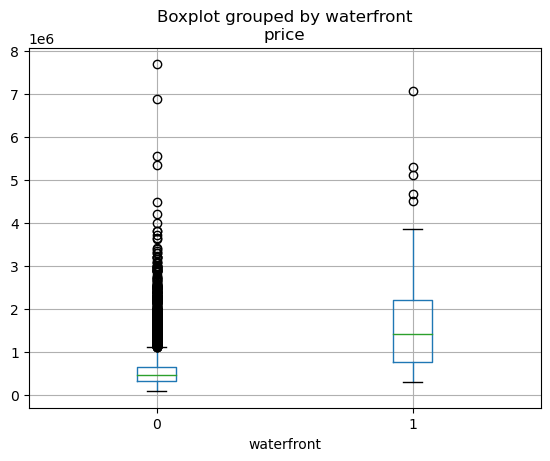

In [19]:
# Sólo representamos 5: bathrooms, sqm_living, years, bedrooms y waterfront
# el resto se puede repetir una a una

house_data.plot(kind = 'scatter',x='bathrooms',y = 'price')
plt.xlabel('bathrooms')
plt.ylabel('price ($)')
plt.show()

house_data.plot(kind = 'scatter',x='sqm_living',y = 'price')
plt.xlabel('sqm_living ($m^2$)')
plt.ylabel('price ($)')
plt.show()

house_data.plot(kind = 'scatter',x='years',y = 'price')
plt.xlabel('years')
plt.ylabel('price ($)')
plt.show()

house_data.plot(kind = 'scatter',x='bedrooms',y = 'price')
plt.xlabel('bedrooms')
plt.ylabel('price ($)')
plt.show()

house_data.boxplot(by='waterfront',column = 'price')
plt.show()

Observamos una cantidad bastante llamativa de outliers, sin embargo preferiremos no eliminarlos ya que a la mayoría de algoritmos que aplicaremos apenas le van a afectar.

### Correlaciones entre las variables:

Realizamos ahora la matriz de correlaciones para ver si existe correlación entre los atributos para intentar evitar la colinealidad entre las variables, ya que en los algoritmos de machine learning esto suele inducir a error.

<AxesSubplot:>

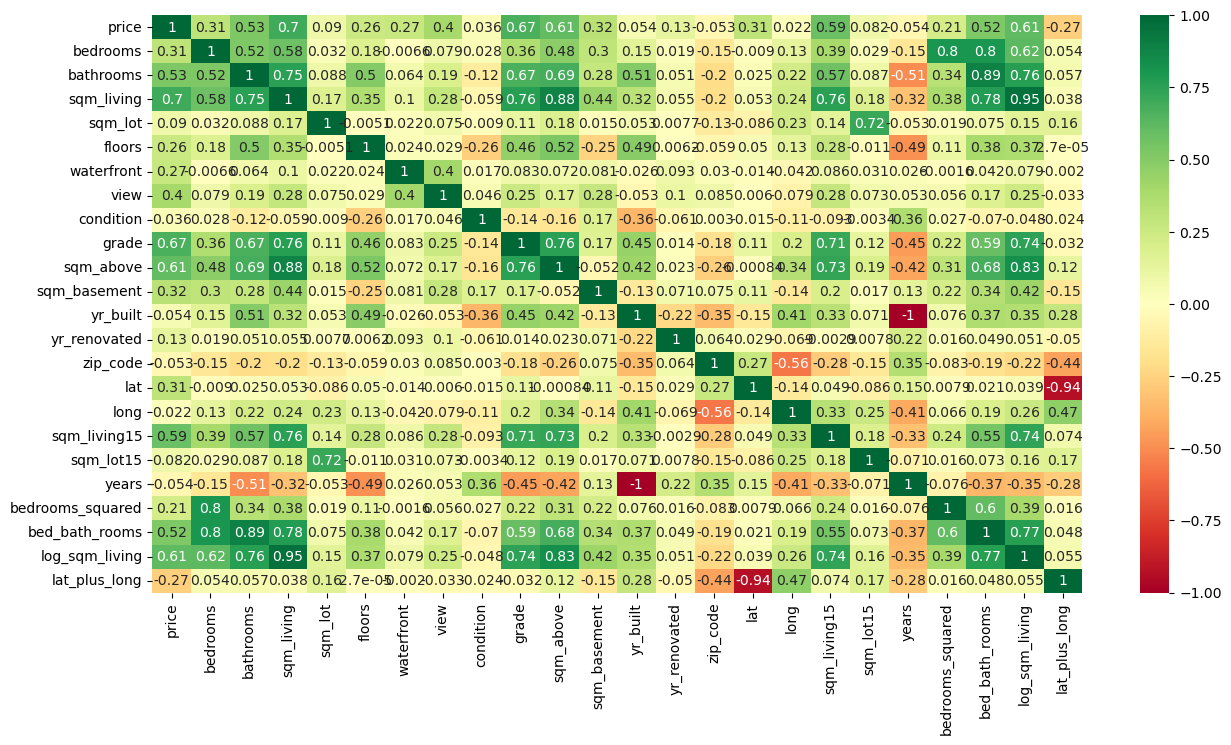

In [20]:
plt.figure(figsize=(15,7.5))
sns.heatmap(house_data.corr(), annot=True, vmin=-1, vmax=+1, cmap='RdYlGn')

Después de ver esta matriz de correlaciones hay muchas variables que podemos eliminar por redundancia respecto a otras. Podemos usar como valor límite un criterio del 0.7, es decir, que si la correlacion lineal es mayor que el 0.7 eliminamos la variable. Por ejemplo: years con yr_built.

Emplaremos la función definida más arriba, *collinear_features*, para saber qué variables cumplen este criterio.

In [21]:
atributos=house_data.drop('price',axis=1)
remove_collinear_features(atributos, 0.7) # Función que nos advierte muestra que variables están muy correlacionadas.

sqm_living | bathrooms | 0.75
grade | sqm_living | 0.76
sqm_above | sqm_living | 0.88
sqm_above | grade | 0.76
sqm_living15 | sqm_living | 0.76
sqm_living15 | grade | 0.71
sqm_living15 | sqm_above | 0.73
sqm_lot15 | sqm_lot | 0.72
years | yr_built | 1.0
bedrooms_squared | bedrooms | 0.8
bed_bath_rooms | bedrooms | 0.8
bed_bath_rooms | bathrooms | 0.89
bed_bath_rooms | sqm_living | 0.78
log_sqm_living | bathrooms | 0.76
log_sqm_living | sqm_living | 0.95
log_sqm_living | grade | 0.74
log_sqm_living | sqm_above | 0.83
log_sqm_living | sqm_living15 | 0.74
log_sqm_living | bed_bath_rooms | 0.77
lat_plus_long | lat | 0.94


,bedrooms,bathrooms,sqm_lot,floors,waterfront,view,condition,sqm_basement,yr_built,yr_renovated,zip_code,lat,long
0,3,1.00,524.902176,1.0,0,0,3,0.000000,1955,0,98178,47.5112,-122.257
1,3,2.25,672.803816,2.0,0,0,3,37.161216,1951,1991,98125,47.7210,-122.319
2,2,1.00,929.030400,1.0,0,0,3,0.000000,1933,0,98028,47.7379,-122.233
3,4,3.00,464.515200,1.0,0,0,5,84.541766,1965,0,98136,47.5208,-122.393
4,3,2.00,750.656563,1.0,0,0,3,0.000000,1987,0,98074,47.6168,-122.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,105.073338,3.0,0,0,3,0.000000,2009,0,98103,47.6993,-122.346
21609,4,2.50,540.045372,2.0,0,0,3,0.000000,2014,0,98146,47.5107,-122.362
21610,2,0.75,125.419104,2.0,0,0,3,0.000000,2009,0,98144,47.5944,-122.299
21611,3,2.50,221.852460,2.0,0,0,3,0.000000,2004,0,98027,47.5345,-122.069


Por tanto los valores con más de un 70% de correlación son: *'sqm_living',  'grade', 'sqm_above', 'sqm_living15', 'sqm_lot15', 'bedrooms_squared', 'yr_built', 'bed_bath_rooms', 'log_sqm_living' y 'lat_plus_long'*.

In [22]:
atributos=atributos.drop(['sqm_living', 'grade', 'sqm_above', 'sqm_living15', 'sqm_lot15','bedrooms_squared','yr_built','bed_bath_rooms','log_sqm_living','lat_plus_long'], axis=1)

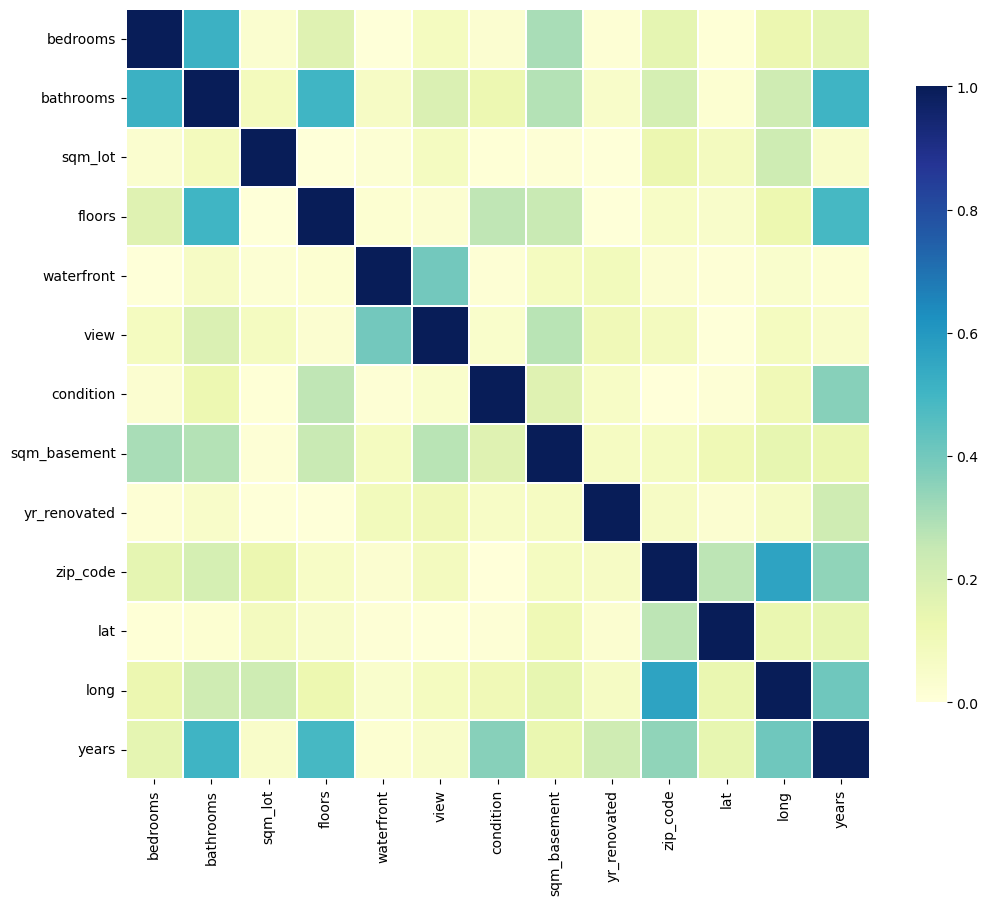

In [23]:
# Compute the correlation matrix
corr = np.abs(atributos.corr())

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

### Importancia de cada variable a la hora de clasificar la variable objetivo

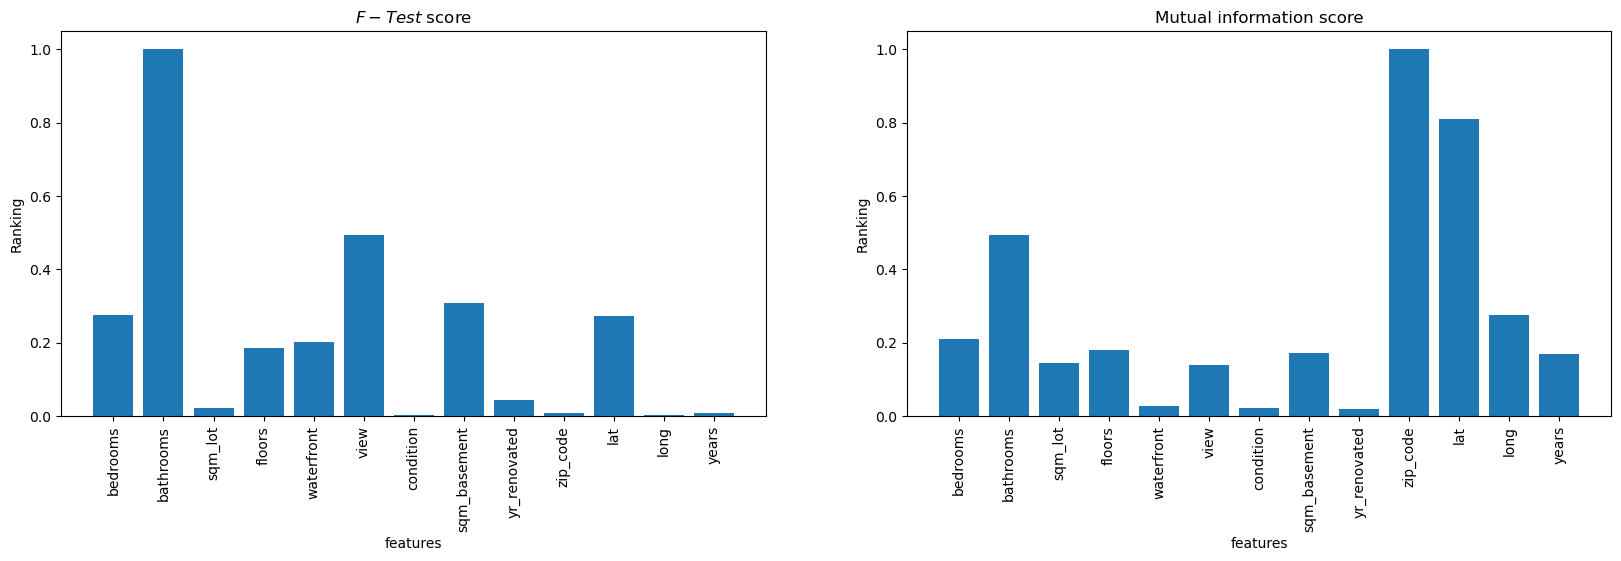

In [24]:
from sklearn.feature_selection import f_regression, mutual_info_regression

# convertimos el DataFrame al formato necesario para scikit-learn
data = atributos 

y = house_data['price']     # nos quedamos con la 1ª columna, price
X = data     # nos quedamos con el resto

feature_names = atributos.columns


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

Observamos que las variables que más explican el precio de la compra de las casas son 'bathrooms', 'zip_code' y 'lat'.

## Aplicación de algoritmos

### Reescalado de los datos

Ahora reescalaremos los datos, para que nuestros diversos algoritmos tengan mejores resultados.

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
# separar las características de la variable objetivo
X = atributos
y = house_data['price']

# crear una instancia del transformador StandardScaler
scaler = StandardScaler()

# ajustar y transformar los datos
X_t = scaler.fit_transform(X)

In [27]:
X = atributos
y = house_data['price'] # Variable objetivo

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Como nuestra variable objetivo es de tipo continua haremos análisis de regresión en lugar de análisis de clasificación. Además no podremos hacer balanceo de los datos como tal pues no tendremos clases enteras para cada valor de price.

### División en Train y Test:

En primer lugar dividiermos los datos en Train y Test empleando la función train_test_split con una proporción de un 80% Train y un 20% Test.

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# Dividimos la muestra
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2, random_state=42)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

Datos entrenamiento:  (17286, 13)
Datos test:  (4322, 13)


In [30]:
y_log = house_data_log['price'] # Variable objetivo

# Dividimos la muestra
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_t, y_log, test_size=0.2, random_state=42)

print('Datos entrenamiento: ', X_train_l.shape)
print('Datos test: ', X_test_l.shape)

Datos entrenamiento:  (17286, 13)
Datos test:  (4322, 13)


### Modelo A: Regresión lineal

In [31]:
from sklearn.linear_model import LinearRegression

#### Resultados sin transformar la variable 'price' con la función logaritmica

In [32]:
lin_reg = LinearRegression()
model = lin_reg.fit(X_train, y_train)

linreg_y_pred = model.predict(X_test)

rmse, rsq, mae = algoritmo_regresion(y_test, linreg_y_pred)
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 258808.85472843662, R2 Score: 0.5295095384059075 y MAE: 160561.6308922817.


#### Resultados transformando la variable 'price' con la función logaritmica

In [33]:
lin_reg = LinearRegression()
model = lin_reg.fit(X_train_l, y_train_l)

linreg_y_pred_l = model.predict(X_test_l)

rmse, rsq, mae = algoritmo_regresion(np.exp(y_test_l), np.exp(linreg_y_pred_l))
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 252710.6474692461, R2 Score: 0.5514202730007229 y MAE: 147732.11702023822.


### Modelo B: Regresión K-NN

In [34]:
from sklearn.neighbors import KNeighborsRegressor

#### Búsqueda de hiperparámetros:

In [35]:
def plot_complexity_curve(k_list, knn_model, x_train, x_test, y_train, y_test):
    
    train_scores = []
    test_scores = []
    
    # For each k
    for k in k_list:
        # Initialize, fit, predict
        knn = knn_model(k)
        
        knn.fit(x_train, y_train)
        
        train_scores.append(knn.score(x_train, y_train))
        test_scores.append(knn.score(x_test, y_test))

    # Plot
    fig, ax = plt.subplots()
    
    ax.plot(k_list, train_scores, label='Training Accuracy', color='red')
    ax.plot(k_list, test_scores, label='Testing Accuracy', color='black')

    ax.set(title='k-NN with Different Values for $k$',
           xlabel='Number of Neighbors',
           ylabel='Accuracy')
    
    ax.legend()

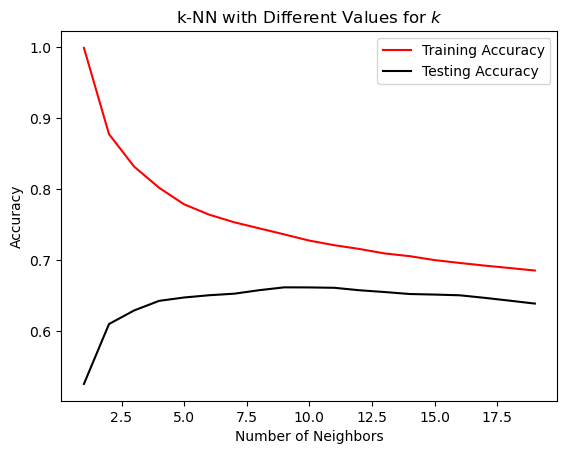

In [36]:
nn_reg = KNeighborsRegressor(n_neighbors=15)
neighbors = np.arange(1, 20)
plot_complexity_curve(neighbors, KNeighborsRegressor, X_train, X_test, y_train, y_test)

De la gráfica anterior concluimos que parece razonable tomar n_neighbors=15, ya que un numero mayor no mejora sustancialmente y requiere mucha más potencia computacional.

In [37]:
knn_reg = KNeighborsRegressor(n_neighbors=15)
model = knn_reg.fit(X_train, y_train)

knn_y_pred = model.predict(X_test)

rmse, rsq, mae = algoritmo_regresion(y_test, knn_y_pred)
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 222829.1493877073, R2 Score: 0.6512320519150533 y MAE: 118054.15694894339.


#### Resultados transformando la variable 'price' con la función logaritmica

In [38]:
knn_reg = KNeighborsRegressor(n_neighbors=15)
model = knn_reg.fit(X_train_l, y_train_l)

knn_y_pred_l = model.predict(X_test_l)

rmse, rsq, mae = algoritmo_regresion(np.exp(y_test_l), np.exp(knn_y_pred_l))
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 229963.22045466097, R2 Score: 0.6285423342174103 y MAE: 117107.71258586989.


### Modelo C:  Arbol de decisión simple

In [39]:
from sklearn.tree import DecisionTreeRegressor

#### Busqueda de hiperparámetros:

In [40]:
for max_d in range(1,21):
  dt_reg = DecisionTreeRegressor(max_depth=max_d, random_state=42)
  model = dt_reg.fit(X_train, y_train)

  dt_y_pred = model.predict(X_test)

  print('The RMSE for max_depth {} is:'.format(max_d),  np.sqrt(mean_squared_error(y_test, dt_y_pred)))
  print('The RSQ for max_depth {} is:'.format(max_d),  r2_score(y_test, dt_y_pred))
  print('The MAE for max_depth {} is:'.format(max_d),  mean_absolute_error(y_test, dt_y_pred))

  np.sqrt(mean_squared_error(y_test, dt_y_pred))
  print('')

The RMSE for max_depth 1 is: 328179.9550350791
The RSQ for max_depth 1 is: 0.24348653256079444
The MAE for max_depth 1 is: 212097.23002542235

The RMSE for max_depth 2 is: 295477.83387057146
The RSQ for max_depth 2 is: 0.3867431971414641
The MAE for max_depth 2 is: 179652.21613174508

The RMSE for max_depth 3 is: 282959.6583261502
The RSQ for max_depth 3 is: 0.43760479893874926
The MAE for max_depth 3 is: 167157.61982854147

The RMSE for max_depth 4 is: 270766.8619979597
The RSQ for max_depth 4 is: 0.4850280370645982
The MAE for max_depth 4 is: 156653.1879775881

The RMSE for max_depth 5 is: 260258.9208062033
The RSQ for max_depth 5 is: 0.5242225979104721
The MAE for max_depth 5 is: 148264.06568784604

The RMSE for max_depth 6 is: 245415.86966122538
The RSQ for max_depth 6 is: 0.5769440117717983
The MAE for max_depth 6 is: 139761.9616539043

The RMSE for max_depth 7 is: 233150.38955816903
The RSQ for max_depth 7 is: 0.6181745676035835
The MAE for max_depth 7 is: 130991.16358189241

The

Por tanto tomaremos el hiperparámetro max_depth = 16.

In [41]:
dt_reg = DecisionTreeRegressor(max_depth=16)
model = dt_reg.fit(X_train, y_train)

dt_y_pred = model.predict(X_test)

rmse, rsq, mae = algoritmo_regresion(y_test, dt_y_pred)
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 212959.22251108952, R2 Score: 0.6814442368425196 y MAE: 111790.53307841641.


#### Resultados transformando la variable 'price' con la función logaritmica

In [42]:
dt_reg = DecisionTreeRegressor(max_depth=16)
model = knn_reg.fit(X_train_l, y_train_l)

dt_y_pred_l = model.predict(X_test_l)

rmse, rsq, mae = algoritmo_regresion(np.exp(y_test_l), np.exp(dt_y_pred_l))
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 229963.22045466097, R2 Score: 0.6285423342174103 y MAE: 117107.71258586989.


### Modelo D: Bagging

In [43]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV

Podemos tomar el hiperparametro 'max_depth' = 7.

In [44]:
param_grid = {'base_estimator__max_depth' : 7}
b_reg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=200, random_state=0)
model = b_reg.fit(X_train, y_train)

b_y_pred = model.predict(X_test)

rmse, rsq, mae = algoritmo_regresion(y_test, b_y_pred)
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 164261.84301748333, R2 Score: 0.8104752449601943 y MAE: 86937.54699608867.


#### Resultados transformando la variable 'price' con la función logaritmica

In [45]:
b_reg = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=200, random_state=0)
model = b_reg.fit(X_train_l, y_train_l)

b_y_pred_l = model.predict(X_test_l)

rmse, rsq, mae = algoritmo_regresion(np.exp(y_test_l), np.exp(b_y_pred_l))
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 171724.22073043432, R2 Score: 0.7928639596639012 y MAE: 87269.74783054845.


### Modelo E: Random Forest Regression

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
rf_reg = RandomForestRegressor()
model = rf_reg.fit(X_train, y_train)

rf_y_pred = model.predict(X_test)
rmse, rsq, mae = algoritmo_regresion(y_test, rf_y_pred)
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 165702.54588508882, R2 Score: 0.8071361093774503 y MAE: 87289.70329744276.


#### Resultados transformando la variable 'price' con la función logaritmica

In [48]:
rf_reg = RandomForestRegressor()
model = rf_reg.fit(X_train_l, y_train_l)

rf_y_pred_l = model.predict(X_test_l)
rmse, rsq, mae = algoritmo_regresion(np.exp(y_test_l), np.exp(rf_y_pred_l))
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 172763.6249563827, R2 Score: 0.7903488846471309 y MAE: 87981.97722297796.


### Modelo F: GradientBoosting Regression

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

In [50]:
gb_reg = GradientBoostingRegressor(random_state=0)
model = gb_reg.fit(X_train, y_train)

gb_y_pred = model.predict(X_test)

rmse, rsq, mae = algoritmo_regresion(y_test, gb_y_pred)
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 182816.14588154748, R2 Score: 0.7652413198093123 y MAE: 104118.11675152951.


#### Resultados transformando la variable 'price' con la función logaritmica

In [51]:
gb_reg = GradientBoostingRegressor(random_state=0)
model = gb_reg.fit(X_train_l, y_train_l)

gb_y_pred_l = model.predict(X_test_l)

rmse, rsq, mae = algoritmo_regresion(np.exp(y_test_l), np.exp(gb_y_pred_l))
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 184066.27108922676, R2 Score: 0.7620197097528125 y MAE: 100131.26407839183.


### Modelo G:  XGBoost Regression

In [52]:
from xgboost import XGBRegressor

In [53]:
xgb_reg = XGBRegressor()
model = xgb_reg.fit(X_train, y_train)

xgb_y_pred = model.predict(X_test)

rmse, rsq, mae = algoritmo_regresion(y_test, xgb_y_pred)
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 160851.55428503707, R2 Score: 0.8182631128879219 y MAE: 86962.32325167746.


#### Resultados transformando la variable 'price' con la función logaritmica

In [54]:
xgb_reg = XGBRegressor()
model = xgb_reg.fit(X_train_l, y_train_l)

xgb_y_pred_l = model.predict(X_test_l)

rmse, rsq, mae = algoritmo_regresion(np.exp(y_test_l), np.exp(xgb_y_pred_l))
print('Tenemos RMSE: {}, R2 Score: {} y MAE: {}.'.format(rmse,rsq,mae))

Tenemos RMSE: 147422.89200517497, R2 Score: 0.8473409995567772 y MAE: 82466.24105051192.


### Comparación de Modelos

Guararemos los resultados de todos los modelos anteriores en un dataset aparte para facilitar la comparativa entre todos ellos.

In [55]:
scores = {
         'Modelo': ['Regresión lineal','K-NN','Árbol de decisión simple', 'Bagging', 'Random Forest', 'GradientBoost','XGBoost'],
          
         'RMSE': [(np.sqrt(mean_squared_error(y_test, linreg_y_pred))),
                  (np.sqrt(mean_squared_error(y_test, knn_y_pred))),
                  (np.sqrt(mean_squared_error(y_test, dt_y_pred))),
                  (np.sqrt(mean_squared_error(y_test, b_y_pred))),
                  (np.sqrt(mean_squared_error(y_test, rf_y_pred))),
                  (np.sqrt(mean_squared_error(y_test, gb_y_pred))),
                  (np.sqrt(mean_squared_error(y_test, xgb_y_pred))),],
    
         'R2 Score': [(r2_score(y_test, linreg_y_pred)),
                      (r2_score(y_test, knn_y_pred)),
                      (r2_score(y_test, dt_y_pred)),
                      (r2_score(y_test, b_y_pred)),
                      (r2_score(y_test, rf_y_pred)),
                      (r2_score(y_test, gb_y_pred)),
                      (r2_score(y_test, xgb_y_pred))],
    
        'MAE': [(mean_absolute_error(y_test, linreg_y_pred)),
                  (mean_absolute_error(y_test, knn_y_pred)),
                 (mean_absolute_error(y_test, dt_y_pred)),
                 (mean_absolute_error(y_test, b_y_pred)),
                 (mean_absolute_error(y_test, rf_y_pred)),
                 (mean_absolute_error(y_test, gb_y_pred)),
                 (mean_absolute_error(y_test, xgb_y_pred))]
            }

col = ['Modelo', 'RMSE', 'R2 Score', 'MAE']

error_matrix = pd.DataFrame(data=scores, columns=col).sort_values(by='MAE', ascending=True).reset_index()
error_matrix.drop(columns=['index'], inplace=True)

error_matrix

,Modelo,RMSE,R2 Score,MAE
0,Bagging,164261.843017,0.810475,86937.546996
1,XGBoost,160851.554285,0.818263,86962.323252
2,Random Forest,165702.545885,0.807136,87289.703297
3,GradientBoost,182816.145882,0.765241,104118.116752
4,Árbol de decisión simple,212959.222511,0.681444,111790.533078
5,K-NN,222829.149388,0.651232,118054.156949
6,Regresión lineal,258808.854728,0.529510,160561.630892


Podemos observar que el mejor modelo según la métrica MAE es el método de Bagging junto con el XGBoost, no seguido de muy lejos por el Random Forest en la tabla sin transformar por el logaritmo.

La métrica MAE (Error Absoluto Medio, por sus siglas en inglés) se utiliza comúnmente en la evaluación de modelos de regresión. El MAE mide la magnitud promedio de los errores en un conjunto de predicciones, sin tener en cuenta su dirección (positiva o negativa). Es decir, el MAE calcula el promedio de las diferencias absolutas entre las predicciones y los valores reales.

La métrica RMSE (Error Cuadrático Medio de la Raíz, por sus siglas en inglés) es otra métrica comúnmente utilizada en la evaluación de modelos de regresión. El RMSE mide la raíz cuadrada del promedio de las diferencias cuadráticas entre las predicciones y los valores reales.

Nos quedaremós con la métrica MAE que nos ha dado mejor resultado en el análisis

In [56]:
scores = {
         'Modelo': ['Regresión linea log','K-NN log','Árbol de decisión simple log', 'Bagging log', 'Random Forest log', 'GradientBoost log','XGBoost log'],
          
         'RMSE': [(np.sqrt(mean_squared_error(np.exp(y_test_l), np.exp(linreg_y_pred_l)))),
                  (np.sqrt(mean_squared_error(np.exp(y_test_l), np.exp(knn_y_pred_l)))),
                  (np.sqrt(mean_squared_error(np.exp(y_test_l), np.exp(dt_y_pred_l)))),
                  (np.sqrt(mean_squared_error(np.exp(y_test_l), np.exp(b_y_pred_l)))),
                  (np.sqrt(mean_squared_error(np.exp(y_test_l), np.exp(rf_y_pred_l)))),
                  (np.sqrt(mean_squared_error(np.exp(y_test_l), np.exp(gb_y_pred_l)))),
                  (np.sqrt(mean_squared_error(np.exp(y_test_l), np.exp(xgb_y_pred_l)))),],
    
         'R2 Score': [(r2_score(np.exp(y_test_l), np.exp(linreg_y_pred_l))),
                      (r2_score(np.exp(y_test_l), np.exp(knn_y_pred_l))),
                      (r2_score(np.exp(y_test_l), np.exp(dt_y_pred_l))),
                      (r2_score(np.exp(y_test_l), np.exp(b_y_pred_l))),
                      (r2_score(np.exp(y_test_l), np.exp(rf_y_pred_l))),
                      (r2_score(np.exp(y_test_l), np.exp(gb_y_pred_l))),
                      (r2_score(np.exp(y_test_l), np.exp(xgb_y_pred_l)))],
    
        'MAE': [(mean_absolute_error(np.exp(y_test_l), np.exp(linreg_y_pred_l))),
                  (mean_absolute_error(np.exp(y_test_l), np.exp(knn_y_pred_l))),
                 (mean_absolute_error(np.exp(y_test_l), np.exp(dt_y_pred_l))),
                 (mean_absolute_error(np.exp(y_test_l), np.exp(b_y_pred_l))),
                 (mean_absolute_error(np.exp(y_test_l), np.exp(rf_y_pred_l))),
                 (mean_absolute_error(np.exp(y_test_l), np.exp(gb_y_pred_l))),
                 (mean_absolute_error(np.exp(y_test_l), np.exp(xgb_y_pred_l)))]
            }

col = ['Modelo', 'RMSE', 'R2 Score', 'MAE']

error_matrix2 = pd.DataFrame(data=scores, columns=col).sort_values(by='MAE', ascending=True).reset_index()
error_matrix2.drop(columns=['index'], inplace=True)

error_matrix2

,Modelo,RMSE,R2 Score,MAE
0,XGBoost log,147422.892005,0.847341,82466.241051
1,Bagging log,171724.220730,0.792864,87269.747831
2,Random Forest log,172763.624956,0.790349,87981.977223
3,GradientBoost log,184066.271089,0.762020,100131.264078
4,K-NN log,229963.220455,0.628542,117107.712586
5,Árbol de decisión simple log,229963.220455,0.628542,117107.712586
6,Regresión linea log,252710.647469,0.551420,147732.117020


Esta tabla de arriba representa las métricas de los algoritmos cuya variable objetivo esta transformada por el logaritmo. Observamos que hay métodos que empeoran en métricas, como el k-NN y otros que mejoran sustancialmente como el XGBoost.

Ahora nuestro mejor método es el XGBoost con un MAE de tan solo 82466.24